In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/train"
test_dir = "/kaggle/input/clahe-esrgan-split-fundus-dataset/test"
img_size = (224, 224)
batch_size = 32
epochs = 50  # İlk eğitim için epoch sayısı

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 17524 files belonging to 8 classes.
Found 4384 files belonging to 8 classes.


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ResNet50 modelini yükle (transfer öğrenme)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')  # Sınıf sayısı
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_model.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 248s 432ms/step - accuracy: 0.7290 - loss: 0.8435 - val_accuracy: 0.8403 - val_loss: 0.3895
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 225s 410ms/step - accuracy: 0.8402 - loss: 0.4518 - val_accuracy: 0.8654 - val_loss: 0.3614
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 219s 399ms/step - accuracy: 0.8485 - loss: 0.4195 - val_accuracy: 0.8618 - val_loss: 0.3567
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 223s 407ms/step - accuracy: 0.8557 - loss: 0.3980 - val_accuracy: 0.8714 - val_loss: 0.3404
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 222s 404ms/step - accuracy: 0.8570 - loss: 0.3867 - val_accuracy: 0.8636 - val_loss: 0.3428
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 222s 404ms/step - accuracy: 0.8616 - loss: 0.3779 - val_accuracy: 0.8768 - val_loss: 0.3295
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 220s 401ms/step - accuracy: 0.8636 - loss: 0.3740 - val_accuracy: 0.8734 - val_loss: 0.3315
Epoch 8/50
548/548 ━━━━━━

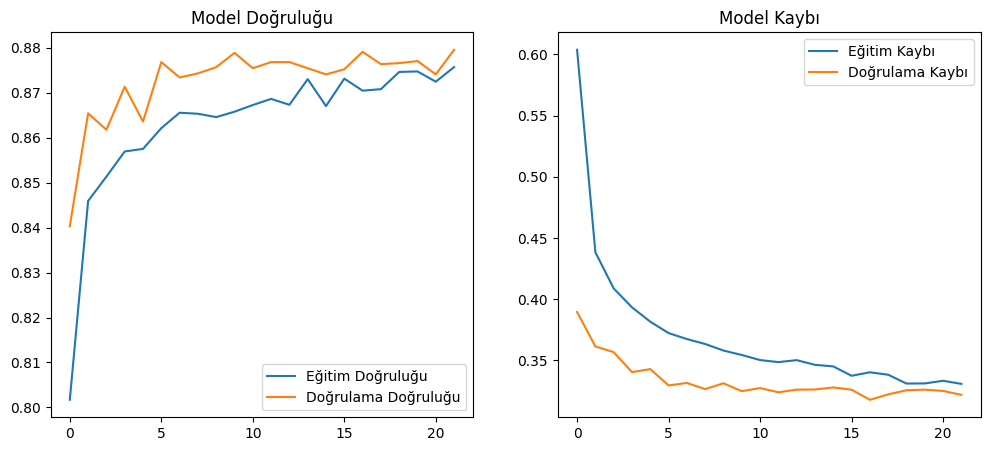

In [3]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

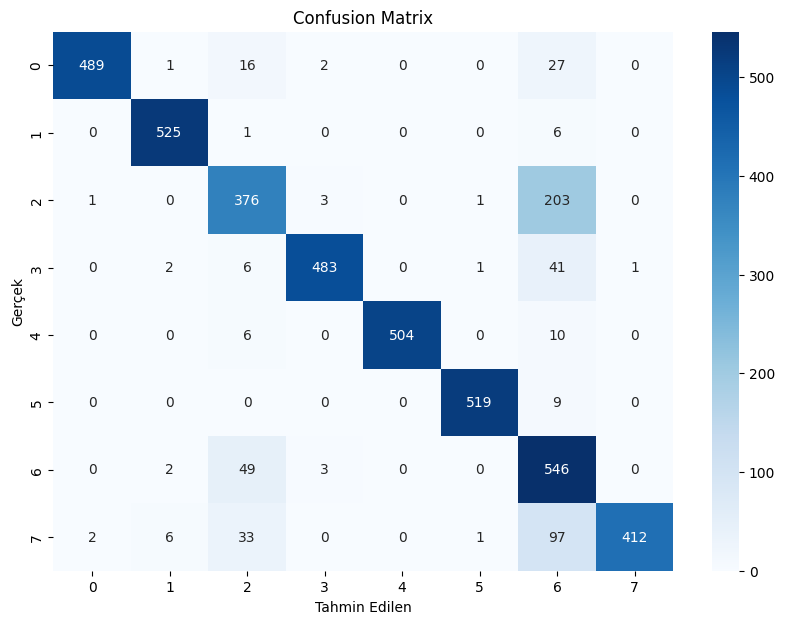

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

Attention

In [6]:
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, Multiply, Add, Activation

class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.global_avg_pool = GlobalAveragePooling2D()
        self.global_max_pool = tf.reduce_max
        self.dense1 = Dense(units=1, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(units=1, kernel_initializer='he_normal', use_bias=False)
        self.reshape = Reshape((1, 1, -1))
        self.add = Add()
        self.activation = Activation('sigmoid')
        self.multiply = Multiply()

    def call(self, inputs):
        channel = inputs.shape[-1]
        
        # Global Average Pooling
        avg_pool = self.global_avg_pool(inputs)
        avg_pool = self.reshape(avg_pool)
        
        # Global Max Pooling
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        
        # Shared MLP
        avg_pool = self.dense1(avg_pool)
        max_pool = self.dense1(max_pool)
        
        avg_pool = self.dense2(avg_pool)
        max_pool = self.dense2(max_pool)
        
        # Add and Sigmoid
        channel_attention = self.add([avg_pool, max_pool])
        channel_attention = self.activation(channel_attention)
        
        return self.multiply([inputs, channel_attention])

In [7]:
from tensorflow.keras.layers import Conv2D, Concatenate

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.concat = Concatenate(axis=-1)
        self.conv = Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal')
        self.multiply = Multiply()

    def call(self, inputs):
        # Average Pooling and Max Pooling along the channel axis
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        
        # Concatenate along the channel axis
        concat = self.concat([avg_pool, max_pool])
        
        # Convolution layer
        spatial_attention = self.conv(concat)
        
        return self.multiply([inputs, spatial_attention])

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ResNet50 modelini yükle (transfer öğrenme)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Input layer
inputs = Input(shape=(224, 224, 3))

# ResNet50 modelini kullan
x = base_model(inputs)

# Channel Attention ekle
x = ChannelAttention(ratio=8)(x)

# Spatial Attention ekle
x = SpatialAttention(kernel_size=7)(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output Layer
outputs = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)  # Sınıf sayısı

# Modeli oluştur
model = Model(inputs, outputs)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=2e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_with_attention.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 237s 413ms/step - accuracy: 0.7033 - loss: 0.9101 - val_accuracy: 0.8613 - val_loss: 0.3739
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 221s 403ms/step - accuracy: 0.8439 - loss: 0.4439 - val_accuracy: 0.8684 - val_loss: 0.3627
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 220s 402ms/step - accuracy: 0.8525 - loss: 0.4137 - val_accuracy: 0.8688 - val_loss: 0.3437
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 219s 399ms/step - accuracy: 0.8578 - loss: 0.3935 - val_accuracy: 0.8661 - val_loss: 0.3441
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 221s 403ms/step - accuracy: 0.8564 - loss: 0.3830 - val_accuracy: 0.8782 - val_loss: 0.3329
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 223s 406ms/step - accuracy: 0.8649 - loss: 0.3721 - val_accuracy: 0.8773 - val_loss: 0.3352
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 220s 401ms/step - accuracy: 0.8636 - loss: 0.3676 - val_accuracy: 0.8775 - val_loss: 0.3285
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 218s 397ms/step - accuracy: 0.8634 -

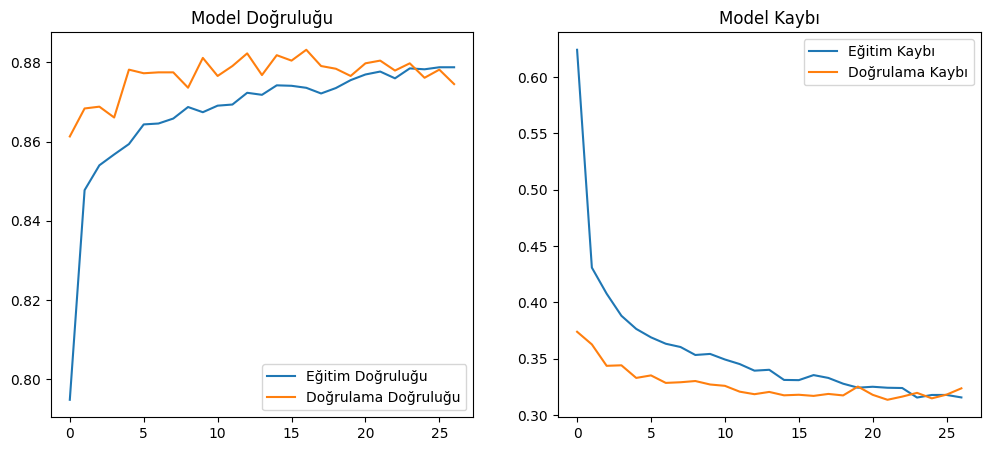

In [9]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

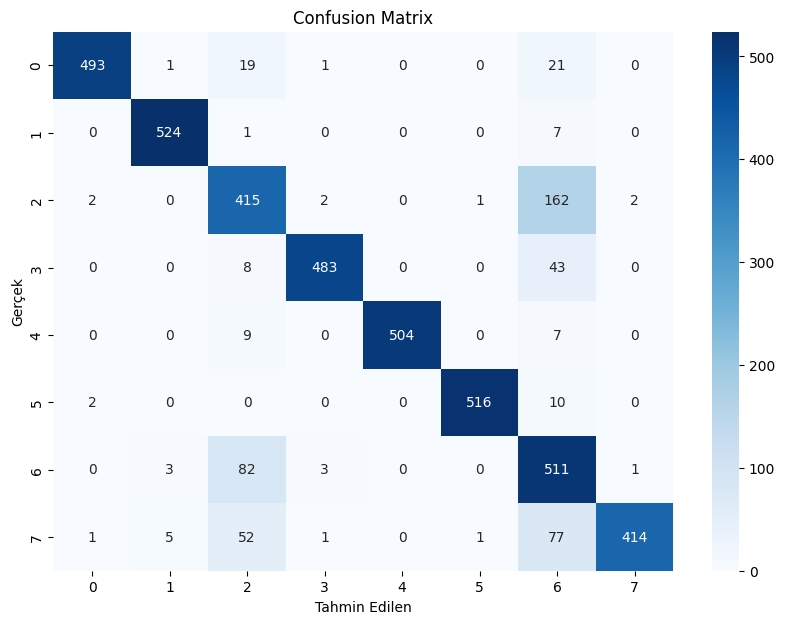

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)

# Confusion matrix'i görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cmp, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()